In [1]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_pickle('whole_dish_base_2020.pkl')

In [4]:
df.head()

,item_code,frn_id,category,item_name,item_description,item_text,tokens,prep_text
0,40373390.0,45460,Raclettes gourmet,Lyon,Arrachera Texas queso holandés cebolla salte...,raclettes gourmet lyon arrachera texas queso h...,"[raclettes, gourmet, lyon, arrachera, texas, q...",raclettes gourmet lyon arrachera texas queso h...
1,33121114.0,45460,Batidos nutritivos,Appenzell,Mango granola y avena,batidos nutritivos appenzell mango granola y a...,"[batidos, nutritivos, appenzell, mango, granol...",batidos nutritivos appenzell mango granola avena
2,33120324.0,45460,Pastelería,Fantasía bananal,Deliciosos plátanos machos,pastelería fantasía bananal deliciosos plátano...,"[pastelería, fantasía, bananal, plátanos, machos]",pastelería fantasía bananal plátanos machos
3,35429673.0,45460,Pastelería,Flan de cajeta,NaN,pastelería flan de cajeta nan,"[pastelería, flan, cajeta]",pastelería flan cajeta
4,46534290.0,45460,Raclettes,Pastora,Fajitas de pollo al pastor piña caramelizada ...,raclettes pastora fajitas de pollo al pastor p...,"[raclettes, pastora, fajitas, pollo, pastor, p...",raclettes pastora fajitas pollo pastor piña ca...


In [17]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Naive class imbalance correction
imbal = df.T2.value_counts().index[df.T2.value_counts() < 10]

df['T2_isimbal'] = df.T2.map(lambda x: x in list(imbal))
df['T2_corrected'] = df.T2

df.loc[df.T2_isimbal,['T2_corrected']] = 'Otros otros' 


In [18]:
df.loc[[lab in set(['Thai']) for lab in df.T2_corrected],['T2_corrected']] = 'Asiática otros' 
df.loc[[lab in set(['Nachos']) for lab in df.T2_corrected],['T2_corrected']] = 'Botanas otros' 
df.loc[[lab in set(['Bistek']) for lab in df.T2_corrected],['T2_corrected']] = 'Tacos otros' 
df.loc[[lab in set(['Pizza gourmet','Pizza americana']) for lab in df.T2_corrected],['T2_corrected']] = 'Pizza' 
df.loc[[lab in set(['Bagguetes']) for lab in df.T2_corrected],['T2_corrected']] = 'Torta'
df.loc[[lab in set(['Garnachas Otros']) for lab in df.T2_corrected],['T2_corrected']] = 'Garnachas otros'
df.loc[[lab in set(['Tacos Otros']) for lab in df.T2_corrected],['T2_corrected']] = 'Tacos otros'
df.loc[[lab in set(['Internacional Otros']) for lab in df.T2_corrected],['T2_corrected']] = 'Internacional otros'
df.loc[[lab in set(['Bebidas']) for lab in df.T1],['T2_corrected']] = 'Bebidas'

In [19]:
df = df[df['T2_corrected'].notnull()]
df.groupby(['T1'])['T2_corrected'].unique()[8]

array(['Alitas', 'Pollo', 'Nuggets', 'Papas', 'Boneless', 'Otros otros'],
      dtype=object)

In [20]:
df[['tokens','T2_corrected']].to_pickle('tax_train_final.pkl')

In [21]:
# exclude worst 10 classes for test acc
# exclude = set(performance.sort_values(by=['test_accuracy']).head(10).index)

# df = df[[c not in exclude for c in df.T2_corrected]]

# embedding

In [7]:
%%time

import string
import gensim

sentences = df.tokens

# word_model = gensim.models.Word2Vec(sentences, size=100, min_count=1, window=5, iter=15, null_word=0, seed = 2019)
# pretrained_weights = word_model.wv.vectors
# vocab_size, embedding_size = pretrained_weights.shape
# print('Result embedding shape:', pretrained_weights.shape)


Result embedding shape: (78381, 100)
CPU times: user 13min 16s, sys: 2.33 s, total: 13min 18s
Wall time: 4min 52s


In [8]:
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

fname = "w2v_dish_2M.kv"
# word_model.save(fname)


In [24]:
word_model = gensim.models.Word2Vec.load(fname, mmap='r')
pretrained_weights = word_model.wv.vectors


def word2idx(word):
    try:    
        return word_model.wv.vocab[word].index
    except:
        return 0
    
def idx2word(idx):
    return word_model.wv.index2word[idx]


In [25]:
import pickle
# Save
word_model.save("w2v_dish_1M.pkl")  # Stores *.pkl file
# Load
# mymodel = pickle.load("mymodel.pkl")

In [12]:
pretrained_weights.shape

(64935, 100)

In [30]:
# save for tensorboard embedding projector viz
# word_model.wv.save_word2vec_format('dish_w2v')
# shell run: python -m gensim.scripts.word2vec2tensor --input dish_w2v --output dish_w2v

## BiLSTM

In [31]:
# https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2

from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints


def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

## train test split

In [32]:
# # integer encode
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(df.T2_corrected.map(str))
integer_encoded = label_encoder.transform(df.T2_corrected.map(str))
print(integer_encoded)

[ 0 21 52 ... 39 40 26]


In [33]:
label_encoder.classes_

array(['Alitas', 'Arabe', 'Arroces', 'Asiática otros', 'Barbacoa',
       'Bebidas', 'Boneless', 'Botanas otros', 'Bowls', 'Burritos',
       'Caldos', 'Cemitas', 'Chilaquiles', 'Comida china',
       'Comida corrida', 'Cortes', 'Costillas', 'Crepas',
       'Desayunos otros', 'Empanadas', 'Enchiladas', 'Ensalada',
       'Flautas', 'Fruta', 'Garnachas otros', 'Gorditas', 'Hamburguesa',
       'Helados', 'Hot cakes y waffles', 'Hot dog', 'Huevos y omelet',
       'Internacional otros', 'Italiana', 'Mexicana otros', 'Milanesa',
       'Nuggets', 'Otros otros', 'Panes', 'Panini', 'Papas', 'Pasta',
       'Pasteles', 'Pastor', 'Pescado y mariscos', 'Pizza', 'Pollo',
       'Postres otros', 'Pozole', 'Quesadillas', 'Sandwich', 'Sopas',
       'Sushi', 'Tacos otros', 'Tamales', 'Torta', 'Tostadas', 'Vegano'],
      dtype=object)

In [34]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# docs = df.prep_text

# # prepare tokenizer
# t = Tokenizer()
# t.fit_on_texts(df.prep_text)
# vocab_size = len(t.word_index) + 1

# # integer encode the documents
# encoded_docs = t.texts_to_sequences(docs)
# # print(encoded_docs)

# # pad documents to a max length of 4 words
# max_length = 30
# padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# print(padded_docs.shape)


In [35]:
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
y = onehot_encoder.fit_transform(integer_encoded.reshape(-1, 1))

/home/fred/Desktop/taxonomy/env/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [36]:
n_classes = y.shape[1]

In [37]:
max_length = 30

In [38]:
df_newsample = pd.read_pickle('clustering_preproc.pkl')

In [40]:
print('\nPreparing the data for LSTM...')

sentences = df.tokens

X = np.zeros([len(sentences), max_length], dtype=np.int32) 
for i, sentence in enumerate(sentences):
    for t, word in enumerate(sentence[:max_length]):
        X[i, t] = word2idx(word)
            
print('X shape:', X.shape)



Preparing the data for LSTM...
X shape: (5833, 30)


In [41]:
from sklearn.model_selection import train_test_split

# X = padded_docs
# le.inverse_transform([0, 0, 1, 2])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [43]:
pretrained_weights.shape

(64935, 100)

In [44]:
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
y = onehot_encoder.fit_transform(integer_encoded.reshape(-1, 1))

/home/fred/Desktop/taxonomy/env/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [45]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, Dropout, GRU, Concatenate


def BidLstm(maxlen, max_features, embed_size, embedding_matrix, n_classes):
    inp = Input(shape=(maxlen, ))
    emb = Embedding(max_features, embed_size, weights=[embedding_matrix],
                  trainable=False)(inp)
    
    convs = [Bidirectional(LSTM(250, return_sequences=True, dropout=0.1,
                           recurrent_dropout=0.1))(emb),
            Bidirectional(GRU(250, return_sequences=True, dropout=0.1,
                           recurrent_dropout=0.1))(emb)]
    
    x = Concatenate(axis = 1)(convs)
    x = AttentionWithContext()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(n_classes, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)

    return model


In [46]:
from keras.layers import Conv1D,  GlobalMaxPooling1D, Concatenate,MaxPool1D,GlobalAveragePooling1D
def att(maxlen, vocab_size, embed_dim, embedding_matrix, n_classes):
    inp = Input(shape=(maxlen, ))
    emb = Embedding(input_dim=vocab_size,
                   output_dim=embed_dim,
                   mask_zero=True,
                   input_length=maxlen)(inp)
    
    bis = Bidirectional(LSTM(300, return_sequences=True, dropout=0.2,
                           recurrent_dropout=0.2))(emb)
    
#     conv1 = Conv1D(filters = 30, kernel_size = 10, activation = 'relu')(bis)
#     conv2 = Conv1D(filters = 40, kernel_size = 5, activation = 'relu')(bis)
#     conv3 = Conv1D(filters = 30, kernel_size = 10, activation = 'relu')(emb)
#     conv4 = Conv1D(filters = 40, kernel_size = 5, activation = 'relu')(emb)
    
    x = AttentionWithContext()(bis)
    
#     ensembl = [AttentionWithContext()(bis),GlobalAveragePooling1D()(conv1),
#               GlobalAveragePooling1D()(conv2),GlobalAveragePooling1D()(conv3),
#                GlobalAveragePooling1D()(conv4)]

#     x = Concatenate(axis = 1)(ensembl)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.2)(x)
    
    x = Dense(n_classes, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)

    return model

In [47]:
from keras.layers import Conv1D,  GlobalMaxPooling1D, Concatenate,MaxPool1D,GlobalAveragePooling1D
def ensemble(maxlen, vocab_size, embed_dim, embedding_matrix, n_classes):
    inp = Input(shape=(maxlen, ))
    emb = Embedding(input_dim=vocab_size,
                   output_dim=embed_dim,
                   input_length=maxlen,
                   weights=[embedding_matrix],
                   trainable=False)(inp)
    
    bis = Bidirectional(LSTM(300, return_sequences=True, dropout=0.2,
                           recurrent_dropout=0.2))(emb)
    
    conv1 = Conv1D(filters = 30, kernel_size = 10, activation = 'relu')(bis)
    conv2 = Conv1D(filters = 40, kernel_size = 5, activation = 'relu')(bis)
    conv3 = Conv1D(filters = 30, kernel_size = 10, activation = 'relu')(emb)
    conv4 = Conv1D(filters = 40, kernel_size = 5, activation = 'relu')(emb)

    ensembl = [AttentionWithContext()(bis),GlobalAveragePooling1D()(conv1),
              GlobalAveragePooling1D()(conv2),GlobalAveragePooling1D()(conv3),
               GlobalAveragePooling1D()(conv4)]

    x = Concatenate(axis = 1)(ensembl)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.2)(x)
    
    x = Dense(n_classes, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)

    return model

In [92]:
vocab_size, embedding_size = pretrained_weights.shape

model = ensemble(maxlen=max_length,
                vocab_size= vocab_size,
                embed_dim= embedding_size,
                embedding_matrix=pretrained_weights,
                n_classes=n_classes)

In [93]:
# # Load TENSORBOARD
# %reload_ext tensorboard
# # Start TENSORBOARD
# %tensorboard --logdir ./logs

In [94]:
from keras.utils import plot_model
# plot_model(model, to_file='bilstm_att_cnn.png')

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 30, 100)      6493500     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 30, 600)      962400      embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 21, 30)       180030      bidirectional_3[0][0]            
____________________________________________________________________________________________

In [95]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
np.random.seed(7)

model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
file_path = ".model.hdf5"
# ckpt = ModelCheckpoint(file_path, monitor='val_loss', verbose=1,
#                            save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=15)
# tensorBoard = TensorBoard(log_dir = "./logs", histogram_freq = 1)


In [96]:
model.fit(X_train, y_train, batch_size=500, epochs=100, validation_split=0.1, callbacks=[ early])
#model.fit(xtr, y, batch_size=256, epochs=1, validation_split=0.1)

Train on 4199 samples, validate on 467 samples
Epoch 1/100
4199/4199 [==============================] - 13s 3ms/step - loss: 3.1124 - acc: 0.2951 - val_loss: 2.1051 - val_acc: 0.5310
Epoch 2/100
4199/4199 [==============================] - 10s 2ms/step - loss: 1.8964 - acc: 0.5839 - val_loss: 1.4233 - val_acc: 0.6531
Epoch 3/100
4199/4199 [==============================] - 12s 3ms/step - loss: 1.3736 - acc: 0.6783 - val_loss: 1.0558 - val_acc: 0.7131
Epoch 4/100
4199/4199 [==============================] - 11s 3ms/step - loss: 1.0880 - acc: 0.7273 - val_loss: 0.8982 - val_acc: 0.7516
Epoch 5/100
4199/4199 [==============================] - 11s 3ms/step - loss: 0.9239 - acc: 0.7607 - val_loss: 0.8114 - val_acc: 0.7580
Epoch 6/100
4199/4199 [==============================] - 11s 3ms/step - loss: 0.8224 - acc: 0.7799 - val_loss: 0.7887 - val_acc: 0.7730
Epoch 7/100
4199/4199 [==============================] - 11s 3ms/step - loss: 0.7295 - acc: 0.7961 - val_loss: 0.7534 - val_acc: 0.7816
E

In [97]:
#model.save('bilstm_attention_cnn_V2.h5')

# Model evaluation

In [103]:
from keras.models import load_model
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

#model = load_model('bilstm_attention_cnn_V1.h5', custom_objects={'AttentionWithContext' : AttentionWithContext},
#                   compile=False)
#model.compile(loss='categorical_crossentropy', optimizer='adam')

In [99]:
accuracy,loss = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy))

Accuracy: 0.861923


In [64]:
from sklearn.metrics import confusion_matrix

In [38]:
X

array([[ 116,   10,   80, ...,    0,    0,    0],
       [  39,  276,   31, ...,    0,    0,    0],
       [  39,  627,   96, ...,    0,    0,    0],
       ...,
       [4194,   98,    0, ...,    0,    0,    0],
       [ 830,   13,   66, ...,    0,    0,    0],
       [ 830,   13, 1989, ...,    0,    0,    0]], dtype=int32)

In [104]:
y_pred = model.predict(X)
y_pred_decoded = np.argmax(y_pred,axis=1)

In [105]:
y_test_decoded = np.argmax(y,axis=1)

In [106]:
confusion_matrix(y_test_decoded, y_pred_decoded)

array([[ 98,   0,   0, ...,   0,   0,   0],
       [  0,   8,   0, ...,   0,   0,   0],
       [  0,   0,  92, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 347,   0,   0],
       [  0,   0,   0, ...,   0,  28,   0],
       [  1,   0,   0, ...,   0,   0,  10]])

In [107]:
import seaborn as sn
import matplotlib.pyplot as plt 

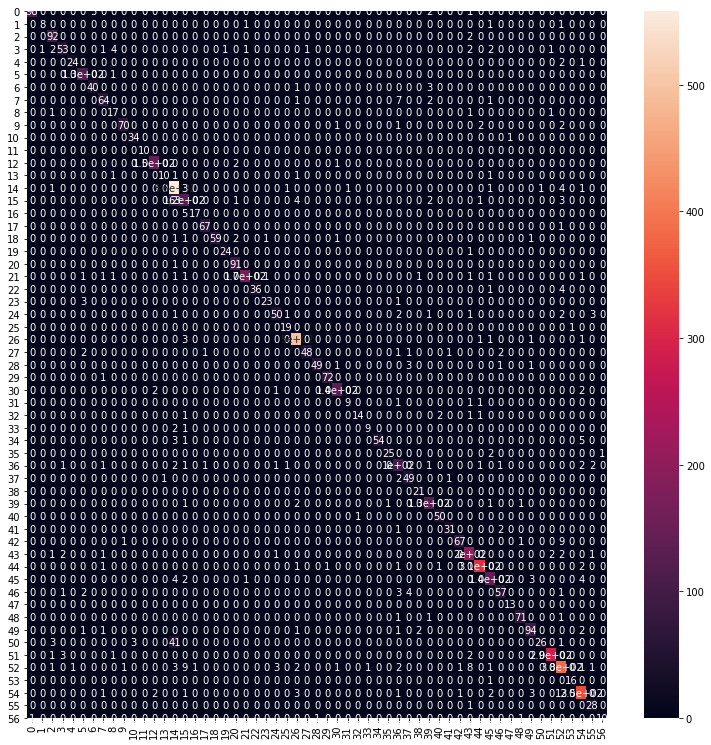

In [108]:
from sklearn import metrics
plt.figure(figsize = (13,13))
sn.heatmap(metrics.confusion_matrix(y_test_decoded, y_pred_decoded), annot=True)


In [109]:
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.metrics import *

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)

    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)


In [110]:
multiclass_roc_auc_score(y_test_decoded,y_pred_decoded)

0.9440276513375991

In [111]:
y_pred_decoded[:15]

array([ 0, 21, 26, 26, 44, 52, 45, 12,  5,  3, 12, 16, 52, 15, 45])

In [112]:
# df_newsample['pred'] = y_pred_decoded
# df_newsample['pred'] = df_newsample['pred'].map(lambda x: label_encoder.inverse_transform([x])[0])

In [67]:
# aux.pred.value_counts()

In [63]:
# aux = df_newsample[df_newsample.pred == label_encoder.inverse_transform([0])[0]].sample(60)
# for i in range(1,n_classes):
#     lab = label_encoder.inverse_transform([i])[0]
#     if lab in ['Vegano','Arabe','Saludable otros','Comida china','Internacional otros']:
#         aux = pd.concat([aux,df_newsample[df_newsample.pred == lab]])
#     elif lab in ['Italiana','Bowls','Saludable otros','Asiatica otros','Mexicana otros','Otros otros','Garnachas otros','Postres otros']:
#         aux = pd.concat([aux,df_newsample[df_newsample.pred == lab].sample(115)])
#     else:
#         aux = pd.concat([aux,df_newsample[df_newsample.pred == lab].sample(62)])

In [68]:
# aux = aux.reset_index()
# len(aux)

In [69]:
# aux[['frn_id','category','item_name_y','item_description_y']].sample(frac=1).to_csv('tax_anotate_V2.csv')

In [113]:
accuracy_score(y_test_decoded, y_pred_decoded)

0.9204525972912738

In [73]:
import random
i = random.randint(0,len(df))

In [76]:
df.item_text[i]

'promociones mediana ing espagueti pizza mediana pulgadas rebanadas con ingredientes al gusto mas litro de espagueti clasico de tomate '

In [171]:
X[i]

array([ 12,  54,  75,   2,   4, 324,  16, 394,  53,   5,   1,  24,   6,
       395,  35,  21,  14,  13,  45,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)

In [77]:
outputs = model.predict(X[i:i+1])

In [78]:
pred_class = np.argmax(outputs,axis=1)
print(pred_class)


[26]


In [79]:
label_encoder.inverse_transform(pred_class)

array(['Hamburguesa'], dtype=object)

In [80]:
label_encoder.inverse_transform([np.argmax(y[i])])

array(['Hamburguesa'], dtype=object)

In [114]:
label_encoder.classes_

array(['Alitas', 'Arabe', 'Arroces', 'Asiática otros', 'Barbacoa',
       'Bebidas', 'Boneless', 'Botanas otros', 'Bowls', 'Burritos',
       'Caldos', 'Cemitas', 'Chilaquiles', 'Comida china',
       'Comida corrida', 'Cortes', 'Costillas', 'Crepas',
       'Desayunos otros', 'Empanadas', 'Enchiladas', 'Ensalada',
       'Flautas', 'Fruta', 'Garnachas otros', 'Gorditas', 'Hamburguesa',
       'Helados', 'Hot cakes y waffles', 'Hot dog', 'Huevos y omelet',
       'Internacional otros', 'Italiana', 'Mexicana otros', 'Milanesa',
       'Nuggets', 'Otros otros', 'Panes', 'Panini', 'Papas', 'Pasta',
       'Pasteles', 'Pastor', 'Pescado y mariscos', 'Pizza', 'Pollo',
       'Postres otros', 'Pozole', 'Quesadillas', 'Sandwich', 'Sopas',
       'Sushi', 'Tacos otros', 'Tamales', 'Torta', 'Tostadas', 'Vegano'],
      dtype=object)

# top n testing

In [81]:
y_test_decoded = np.argmax(y_test,axis=1)

In [82]:
test_accu = []
test_muestras = []
for i in range(n_classes-1):
#     print('Evaluando ' + str(label_encoder.inverse_transform([i])) + ':\n')
    pred = model.predict(X_test[y_test_decoded == i])
    try: 
        pred_decoded = np.argmax(pred,axis=1)
    except:
#         print('Esta clase no está representada')
        test_accu.append(0)
        test_muestras.append(0)
        continue
    acc = accuracy_score(y_test_decoded[y_test_decoded == i], pred_decoded)
    
    test_accu.append(acc)
    test_muestras.append(np.sum([y_test_decoded == i]))
#     print('accuracy: %' + str(acc) + ', con '+ str(np.sum([y_test_decoded == i]))+' muestras en test')

In [83]:
train_accu = []
train_muestras = []

y_train_decoded = np.argmax(y_train,axis=1) 
for i in range(n_classes-1):
#     print('Evaluando ' + str(label_encoder.inverse_transform([i])) + ':\n')
    pred = model.predict(X_train[y_train_decoded == i])
    try: 
        pred_decoded = np.argmax(pred,axis=1)
    except:
#         print('Esta clase no está representada')
        train_accu.append(0)
        train_muestras.append(0)
        continue
    acc = accuracy_score(y_train_decoded[y_train_decoded == i], pred_decoded)
    
    train_accu.append(acc)
    train_muestras.append(np.sum([y_train_decoded == i]))
#     print('accuracy: %' + str(acc) + ', con '+ str(np.sum([y_test_decoded == i]))+' muestras en test')

In [84]:
performance = pd.DataFrame(list(zip(test_accu, test_muestras, train_accu, train_muestras)), 
               columns =['test_accuracy', 'test_samples', 'train_accuracu', 'train_samples'], index = label_encoder.classes_[:-1]) 


In [85]:
performance.sort_values(by=['test_accuracy']).head(30)

,test_accuracy,test_samples,train_accuracu,train_samples
Internacional otros,0.000000,3,1.000000,9
Comida china,0.000000,4,0.900000,10
Mexicana otros,0.000000,1,0.727273,11
Nuggets,0.000000,3,0.960000,25
Sopas,0.157895,19,0.381818,55
Otros otros,0.214286,14,0.882353,102
Costillas,0.400000,5,1.000000,17
Garnachas otros,0.400000,10,0.901961,51
Cortes,0.451613,31,0.580838,167
Bowls,0.500000,2,0.944444,18


In [86]:
performance.sort_values(by=['train_samples']).head(30)

,test_accuracy,test_samples,train_accuracu,train_samples
Cemitas,1.000000,2,1.000000,8
Pozole,1.000000,5,1.000000,8
Arabe,0.500000,2,0.888889,9
Internacional otros,0.000000,3,1.000000,9
Comida china,0.000000,4,0.900000,10
Mexicana otros,0.000000,1,0.727273,11
Tamales,0.750000,4,1.000000,13
Italiana,0.666667,6,1.000000,13
Panini,0.714286,7,1.000000,14
Gorditas,1.000000,4,0.937500,16


In [87]:
len(X)

5833

In [90]:
import matplotlib.pyplot as plt
def label_ploting(category):
    fig, axes = plt.subplots(1, 2)
    
    i = label_encoder.transform([category])[0]

    y_train_decoded = np.argmax(y_train,axis=1)
    pred = model.predict(X_train[y_train_decoded == i])
    pred_decoded = np.argmax(pred,axis=1)
    pd.DataFrame ({'values_': label_encoder.inverse_transform(pred_decoded) }).values_.value_counts()\
    .plot(kind='bar', grid=True, figsize=(16, 7),ax=axes[1],
          title="Predicted for " + category + ' in training data')
    
    y_train_decoded = np.argmax(y_test,axis=1)
    pred = model.predict(X_test[y_test_decoded == i])
    pred_decoded = np.argmax(pred,axis=1)
    pd.DataFrame ({'values_': label_encoder.inverse_transform(pred_decoded) }).values_.value_counts()\
    .plot(kind='bar', grid=True,ax=axes[0],
          title="Predicted for " + category + ' in test data')
    
    print(df[df.T2_corrected == category].sample(7)['item_text'].head(7))


3700    comida viernes tampiqueña de arrachera gr y so...
5739    arma tu pedido wok mezcla de la casa incluye p...
4405    woks chop suey grs dos porciones incluye mezcl...
3129    refresca más tu comida de descuento en pollo s...
1654    tradicionales kung pao famoso platillo picante...
5384               pan chino pan chino de cerdo dulce nan
50      sopas fideo chino fendi fideo cristalino troci...
Name: item_text, dtype: object


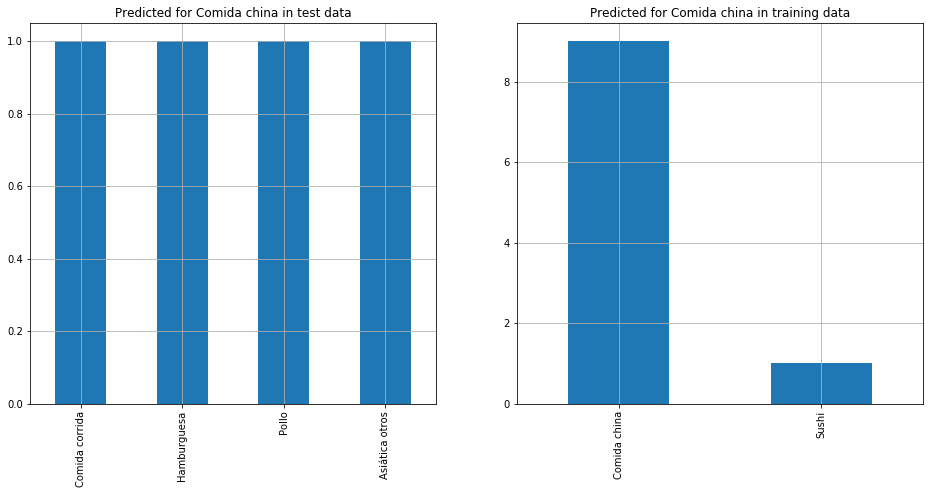

In [91]:
label_ploting('Comida china')

In [63]:
performance.sort_values(by=['train_samples']).head(20)

,test_accuracy,test_samples,train_accuracu,train_samples
Cemitas,1.000000,4,1.000000,8
Arabe,0.000000,2,0.800000,10
Mexicana otros,0.000000,3,0.600000,10
Internacional Otros,0.000000,3,0.636364,11
Saludable otros,0.000000,0,1.000000,11
Comida china,0.500000,4,1.000000,13
Pozole,0.500000,2,1.000000,13
Vegano,1.000000,1,0.846154,13
Bowls,0.166667,6,0.857143,14
Tamales,1.000000,2,1.000000,16


In [64]:
performance.index

Index(['Alitas', 'Arabe', 'Arroces', 'Asiática otros', 'Barbacoa', 'Bebidas',
       'Boneless', 'Botanas otros', 'Bowls', 'Burritos', 'Caldos', 'Cemitas',
       'Chilaquiles', 'Comida china', 'Comida corrida', 'Cortes', 'Costillas',
       'Crepas', 'Desayunos otros', 'Empanadas', 'Enchiladas', 'Ensalada',
       'Flautas', 'Fruta', 'Garnachas Otros', 'Gorditas', 'Hamburguesa',
       'Helados', 'Hot cakes y waffles', 'Hot dog', 'Huevos y omelet',
       'Internacional Otros', 'Italiana', 'Mexicana otros', 'Milanesa',
       'Nuggets', 'Otros otros', 'Panes', 'Panini', 'Papas', 'Pasta',
       'Pasteles', 'Pastor', 'Pescado y mariscos', 'Pizza', 'Pollo',
       'Postres otros', 'Pozole', 'Quesadillas', 'Saludable otros', 'Sandwich',
       'Sopas', 'Sushi', 'Tacos Otros', 'Tacos otros', 'Tamales', 'Torta',
       'Tostadas', 'Vegano'],
      dtype='object')

In [65]:
# class fix

In [66]:
# df.loc[[lab in set(['Thai']) for lab in df.T2_corrected],['T2_corrected']] = 'Asiática otros' 
# df.loc[[lab in set(['Nachos']) for lab in df.T2_corrected],['T2_corrected']] = 'Botanas otros' 
# df.loc[[lab in set(['Bistek']) for lab in df.T2_corrected],['T2_corrected']] = 'Tacos otros' 
# df.loc[[lab in set(['Pizza gourmet','Pizza americana']) for lab in df.T2_corrected],['T2_corrected']] = 'Pizza' 
# df.loc[[lab in set(['Bagguetes']) for lab in df.T2_corrected],['T2_corrected']] = 'Torta' 